# DCGAN

DCGANでMNISTを生成する

In [110]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


batch_size = 64
nz = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## MNIST

In [104]:
dataset = MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

sample_X = next(iter(dataloader))[0]

print("batch shape: ", sample_X.shape)

batch shape:  torch.Size([64, 1, 28, 28])


## Discriminator



In [105]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            self._conv(1, 16, 4, 2, 1),
            self._conv(16, 32, 4, 2, 1),
            self._conv(32, 64, 3, 2, 0),
            nn.Conv2d(64, 128, 3, 1, 0),
            nn.Flatten(),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def _conv(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        y = self.net(x)
        return y

## Generator

In [106]:
class Generator(nn.Module):
    def __init__(self, nz):
        super().__init__()
        self.net = nn.Sequential(
            self._convT(nz, 128, 3, 1, 0),
            self._convT(128, 64, 3, 2, 0),
            self._convT(64, 32, 4, 2, 1),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
            nn.Sigmoid()
        )

    def _convT(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        y = self.net(x)
        return y

## 学習

In [114]:
def write(netG, n_rows=1, n_cols=8, size=64):
    z = torch.randn(n_rows*n_cols, nz, 1, 1, device=device)
    images = netG(z)
    images = transforms.Resize(size)(images)
    img = torchvision.utils.make_grid(images, n_cols)
    img = transforms.functional.to_pil_image(img)
    display(img)

In [112]:
fake_labels = torch.zeros(batch_size, 1).to(device)
real_labels = torch.ones(batch_size, 1).to(device)
criterion = nn.BCELoss()

def train(netD, netG, optimD, optimG, n_epochs, write_interval=1, progress=True):
    netD.train()
    netG.train()
    for epoch in range(n_epochs):
        lossD_list = []
        lossG_list = []
        for X, _ in tqdm(dataloader, disable=not progress):
            X = X.to(device)
            optimD.zero_grad()
            optimG.zero_grad()

            z = torch.randn(batch_size, nz, 1, 1, device=device)
            fake = netG(z)
            pred_fake = netD(fake)
            pred_reak = netD(X)
            loss_fake = criterion(pred_fake, fake_labels)
            loss_real = criterion(pred_reak, real_labels)
            lossD = loss_fake + loss_real
            lossD.backward()
            optimD.step()

            fake = netG(z)
            pred = netD(fake)
            lossG = criterion(pred, real_labels)
            lossG.backward()
            optimG.step()

            lossD_list.append(lossD.item())
            lossG_list.append(lossG.item())

        print(f'{epoch+1:>3}epoch | lossD: {lossD}, lossG: {lossG}')
        if write_interval:
            if epoch % write_interval == 0:
                write(netG)

In [109]:
netD = Discriminator().to(device)
netG = Generator(nz).to(device)
optimD = optim.Adam(netD.parameters(), lr=0.0002)
optimG = optim.Adam(netG.parameters(), lr=0.0002)
n_epochs = 20

lossD, lossG = train(netD, netG, optimD, optimG, n_epochs, None, False)

  1epoch | lossD: 0.34728209538241994, lossG: 3.3050611095550733
  2epoch | lossD: 0.04588143385421389, lossG: 5.877749901551467
  3epoch | lossD: 0.021766913078653697, lossG: 6.922739230669462
  4epoch | lossD: 0.01973095992938257, lossG: 7.223514807529939
  5epoch | lossD: 0.05481657506121943, lossG: 7.333497900229234
  6epoch | lossD: 0.0479126304286556, lossG: 7.092113580459204
  7epoch | lossD: 0.04034603104586355, lossG: 7.539444746115269
  8epoch | lossD: 0.08577327642631598, lossG: 7.516475017254169
  9epoch | lossD: 0.05802757990134593, lossG: 6.449542980927688
 10epoch | lossD: 0.07897538024012764, lossG: 8.124376028012007
 11epoch | lossD: 0.05708085449758726, lossG: 6.947747273322864
 12epoch | lossD: 0.06656115080635899, lossG: 8.256049489363646
 13epoch | lossD: 0.11251117261007237, lossG: 7.255487613188914
 14epoch | lossD: 0.13659735433518505, lossG: 7.219909455531683
 15epoch | lossD: 0.1265205747495668, lossG: 6.6895307791538725
 16epoch | lossD: 0.1882967522415595, l

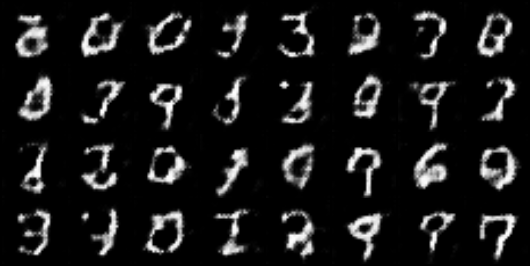

In [115]:
write(netG, 4)